# Imports

In [109]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet
import datetime

# Load Data

In [110]:
#Data Loading
df = pd.read_pickle('./pkl_files/df_10.pkl')

In [111]:
df.head().T

dt,2014-01-01 07:40:00+00:00,2014-01-01 07:50:00+00:00,2014-01-01 08:00:00+00:00,2014-01-01 08:10:00+00:00,2014-01-01 08:20:00+00:00
Ambient Temperature [ºC],9.72157,9.765,9.52833,9.34833,9.45439
Global Radiation [W/m2],7.56779,15.7299,39.1631,56.3454,72.9828
Diffuse Radiation [W/m2],7.22862,13.8266,26.8813,35.3465,49.3996
Ultraviolet [W/m2],0.903016,1.37165,2.09095,2.88017,3.9121
Wind Velocity [m/s],0.623529,0.518333,0.64,0.97,1.23246
Wind Direction [º],281.503,334.33,314.493,302.055,294.46
Current DC [A],0.0704872,0.269625,0.947875,1.18775,1.18382
Power DC [W],1.51494,5.84987,22.1634,29.5072,34.56
Surface Temperature [ºC],9.6,9.825,10.63,11.37,11.6789
Voltage DC [V],24.0471,22.21,23.1475,24.85,29.2316


In [112]:
#df['dt'] = df.index

In [113]:
#mask_year = (df['dt'] >='2015-01-01') & (df['dt'] <'2015-05-01')

In [114]:
#df = df.loc[mask_year]

In [115]:
#df = df.loc[df['PV Cell'] == "A"]

In [116]:
#df.drop(columns=['dt','Current DC [A]','Voltage DC [V]','PV Cell'],inplace=True)
df.drop(columns=['dt','Current DC [A]','Voltage DC [V]'],inplace=True)

In [117]:
df.describe()

,Ambient Temperature [ºC],Global Radiation [W/m2],Diffuse Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [º],Power DC [W],Surface Temperature [ºC]
count,62878.000000,62878.000000,62878.000000,62878.000000,62878.000000,62878.000000,62878.000000,62878.000000
mean,20.834581,445.739926,122.296906,27.088759,2.587359,200.160082,97.701983,29.327085
std,5.575872,315.104396,98.926544,19.429435,1.202525,77.595032,70.788643,9.353802
min,3.519048,0.905725,1.605492,0.503132,0.000000,0.000000,0.000000,2.564286
25%,16.500000,152.374215,57.772826,9.623069,1.721053,130.347100,26.255488,21.660789
50%,20.865001,421.876852,95.106761,24.226669,2.565000,219.609997,96.290506,29.445000
75%,24.980000,713.631046,155.173317,42.964438,3.375000,259.577139,163.802561,36.855000
max,38.071668,1267.771204,698.234880,75.998830,9.435001,357.178000,264.474731,59.400000


In [118]:
df.dtypes

Ambient Temperature [ºC]    float64
Global Radiation [W/m2]     float64
Diffuse Radiation [W/m2]    float64
Ultraviolet [W/m2]          float64
Wind Velocity [m/s]         float64
Wind Direction [º]          float64
Power DC [W]                float64
Surface Temperature [ºC]    float64
dtype: object

In [119]:
df.dropna(thresh=3,inplace=True)

In [120]:
df.isnull().sum()

Ambient Temperature [ºC]    0
Global Radiation [W/m2]     0
Diffuse Radiation [W/m2]    0
Ultraviolet [W/m2]          0
Wind Velocity [m/s]         0
Wind Direction [º]          0
Power DC [W]                0
Surface Temperature [ºC]    0
dtype: int64

# Extract Power

In [121]:
Power = df["Power DC [W]"]

In [122]:
Power.head()

dt
2014-01-01 07:40:00+00:00     1.514945
2014-01-01 07:50:00+00:00     5.849869
2014-01-01 08:00:00+00:00    22.163431
2014-01-01 08:10:00+00:00    29.507244
2014-01-01 08:20:00+00:00    34.560046
Name: Power DC [W], dtype: float64

In [123]:
df.shape

(62878, 8)

In [124]:
#Drop power from df
df_m = df.drop(columns=["Power DC [W]"])

In [125]:
df_m.shape

(62878, 7)

In [126]:
df_m.head().T

dt,2014-01-01 07:40:00+00:00,2014-01-01 07:50:00+00:00,2014-01-01 08:00:00+00:00,2014-01-01 08:10:00+00:00,2014-01-01 08:20:00+00:00
Ambient Temperature [ºC],9.721569,9.765000,9.528333,9.348334,9.454387
Global Radiation [W/m2],7.567789,15.729948,39.163142,56.345415,72.982836
Diffuse Radiation [W/m2],7.228617,13.826647,26.881252,35.346479,49.399562
Ultraviolet [W/m2],0.903016,1.371647,2.090951,2.880174,3.912097
Wind Velocity [m/s],0.623529,0.518333,0.640000,0.970000,1.232456
Wind Direction [º],281.502901,334.330448,314.492646,302.054766,294.459583
Surface Temperature [ºC],9.600000,9.825000,10.630000,11.370000,11.678947


# Train/Test Split

Looking at different splits. 

In [127]:
len(df_m) * .7, len(df_m) * .3, len(df_m) * .8, len(df_m) * .2

(44014.6, 18863.399999999998, 50302.4, 12575.6)

Will do an 80/20 split due to abundance of data. 

In [128]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="Power DC [W]"), 
                                                    df["Power DC [W]"], test_size=0.2, 
                                                    random_state=47)

In [129]:
X_train.shape, X_test.shape

((50302, 7), (12576, 7))

In [130]:
y_train.shape, y_test.shape

((50302,), (12576,))

In [131]:
X_train.dtypes

Ambient Temperature [ºC]    float64
Global Radiation [W/m2]     float64
Diffuse Radiation [W/m2]    float64
Ultraviolet [W/m2]          float64
Wind Velocity [m/s]         float64
Wind Direction [º]          float64
Surface Temperature [ºC]    float64
dtype: object

In [132]:
X_test.dtypes

Ambient Temperature [ºC]    float64
Global Radiation [W/m2]     float64
Diffuse Radiation [W/m2]    float64
Ultraviolet [W/m2]          float64
Wind Velocity [m/s]         float64
Wind Direction [º]          float64
Surface Temperature [ºC]    float64
dtype: object

In [133]:
#names_list = ['PV Cell']
#names_train = X_train[names_list]
#names_test = X_test[names_list]
#X_train.drop(columns=names_list, inplace=True)
#X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((50302, 7), (12576, 7))

In [134]:
X_train.dtypes, X_test.dtypes

(Ambient Temperature [ºC]    float64
 Global Radiation [W/m2]     float64
 Diffuse Radiation [W/m2]    float64
 Ultraviolet [W/m2]          float64
 Wind Velocity [m/s]         float64
 Wind Direction [º]          float64
 Surface Temperature [ºC]    float64
 dtype: object,
 Ambient Temperature [ºC]    float64
 Global Radiation [W/m2]     float64
 Diffuse Radiation [W/m2]    float64
 Ultraviolet [W/m2]          float64
 Wind Velocity [m/s]         float64
 Wind Direction [º]          float64
 Surface Temperature [ºC]    float64
 dtype: object)

# Initial "Model" (the mean)

In [135]:
train_mean = y_train.mean()
train_mean

97.6276784949308

In [136]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[97.62767849]])

In [137]:
y_tr_pred_ = train_mean * np.ones(len(y_train))
y_tr_pred_[:5]

array([97.62767849, 97.62767849, 97.62767849, 97.62767849, 97.62767849])

In [138]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([97.62767849, 97.62767849, 97.62767849, 97.62767849, 97.62767849])

In [139]:
y_te_pred = train_mean * np.ones(len(y_test))

In [140]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -2.743705027885568e-05)

In [141]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(63.32116924478593, 63.43819463327905)

In [142]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(5006.051737688944, 5030.581047822352)

In [143]:
np.sqrt([mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)])

array([70.75345743, 70.92658915])

So using the mean, we are off by ~ 64.4 Watts when prediting power output, which would compound rather astoundingly for day/week prediction. 

# Initial (Actual) Models

We do not have missing data so skipping the fill/drop missing value step.

In [144]:
X_tr = X_train
X_te = X_test

## Scaling the data

In [145]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

## Linear regresion model

In [146]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

In [147]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [148]:
lm_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
lm_r2

(0.8615519012060401, 0.861695448950902)

In [149]:
lm_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
lm_mae

(19.222200270441242, 19.26467219634244)

In [150]:
lm_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
lm_mse

(693.0783455472338, 695.733164469357)

Note! We have not yet removed the voltage/current columns. This great fit is expected as current and voltage exactly explain power (Voltage*Current = Power) and as noted in prior step, current is HIGHLY correlated to Power. 

In [151]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [152]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [153]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [154]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [155]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x124829790>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1, param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7]})

In [156]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [157]:
lr_grid_cv.best_params_

{'selectkbest__k': 7}

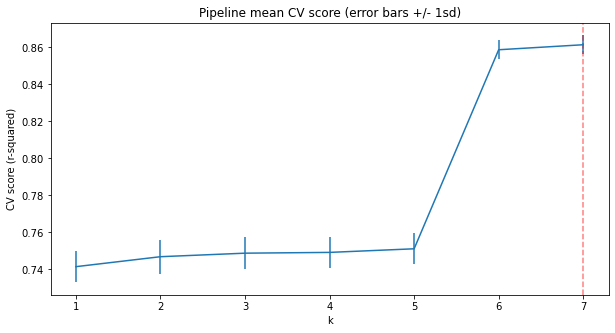

In [158]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [159]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [160]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Global Radiation [W/m2]     81.362160
Surface Temperature [ºC]    28.511744
Wind Velocity [m/s]          1.843956
Diffuse Radiation [W/m2]     1.024400
Wind Direction [º]          -3.851210
Ultraviolet [W/m2]         -26.996826
Ambient Temperature [ºC]   -32.798774
dtype: float64

Insert notes/observations here. 

# Random Forest Model

In [161]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47,n_jobs=-1)
)

In [180]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [181]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.93162012, 0.93883413, 0.93279638, 0.93426404, 0.93269744])

In [182]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.9340424228272644, 0.002539241924801599)

In [1]:
#Note to self: need to change this. []
#n_est = [int(n) for n in np.logspace(start=1, stop=3, num=5)]
grid_params = {
        'randomforestregressor__n_estimators': [120,300,500,800,1200],
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

NameError: name 'StandardScaler' is not defined

In [184]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [185]:
rf_grid_cv.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
rf_grid_cv.best_params_

In [ ]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=3)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

In [ ]:
np.mean(rf_best_scores), np.std(rf_best_scores)

In [ ]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

# Model Performance

Linear Model Performance

In [ ]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [ ]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

In [ ]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

RF Model Performance

In [ ]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)

In [ ]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

In [ ]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

In [ ]:
y_test.min(),y_test.max()

# Save the model

In [ ]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '2.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()
    
modelpath = '../models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
pvmodel_path = os.path.join(modelpath, '4months_A_pv.pkl')
if not os.path.exists(pvmodel_path):
    with open(pvmodel_path, 'wb') as f:
        pickle.dump(best_model, f)